In [106]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import tensorflow as tf

def build_vgg_dotmap_autoencoder(input_shape=(128, 128, 3)):
    # Load VGG16 without top layers, with pretrained weights
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Optionally freeze the encoder
    for layer in vgg_base.layers:
        layer.trainable = False

    inputs = vgg_base.input
    x = vgg_base.output  # shape will be (4, 4, 512) if input is 128x128

    # Decoder: upsample back to original size
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 8x8

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 16x16

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 32x32

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 64x64

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 128x128

    # Final output: 1-channel grayscale dot map
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

In [107]:
import gc

gc.collect()

27091

In [108]:
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
import os

class DotMapGenerator(Sequence):
    def __init__(self, image_dir, map_dir, batch_size=16, target_size=(128, 128), shuffle=True):
        self.image_dir = image_dir
        self.map_dir = map_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png'))]
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        X, Y = [], []
        for fname in batch_files:
            img_path = os.path.join(self.image_dir, fname)
            map_path = os.path.join(self.map_dir, f"dot_{fname}")

            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            dotmap = cv2.imread(map_path, cv2.IMREAD_GRAYSCALE)
            
            img = cv2.resize(img, self.target_size)
            dotmap = cv2.resize(dotmap, self.target_size)
            
            img = img / 255.0
            dotmap = dotmap / 255.0
            dotmap = np.expand_dims(dotmap, axis=-1)


            X.append(img)
            Y.append(dotmap)

        return np.array(X), np.array(Y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_files)


In [109]:
model = build_vgg_dotmap_autoencoder()
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_90 (UpSampling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 8, 8, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_91 (UpSampling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_92 (UpSampling2D) │ (None, 32, 32, 128)    │             

 Total params: 18,641,729 (71.11 MB)

 Trainable params: 3,927,041 (14.98 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_gen = DotMapGenerator("files/cropped", "files/image_dots", batch_size=16)
model.fit(train_gen, epochs=350)

Epoch 1/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.7546
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1202
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3339
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2257
Epoch 5/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1051
Epoch 6/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2405
Epoch 7/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1059
Epoch 8/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1107
Epoch 9/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1335
Epoch 10/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1415
Epoch 11/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1343
Epoch 12/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1198
Epoch 13/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1050
Epoch 14/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0957
Epoch 15/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0946
Epoch 16/250
1/1 ━━━━

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_from_generator(model, generator, n=5):
    """
    Plots up to n predictions from the first batch of the generator.
    """
    # Get the first batch
    X_batch, Y_batch = generator[0]
    total = len(X_batch)

    if total == 0:
        print("[ERROR] No images in batch.")
        return

    n = min(n, total)
    indices = np.random.choice(total, n, replace=False)

    plt.figure(figsize=(12, 4 * n))

    for i, idx in enumerate(indices):
        input_img = X_batch[idx]
        true_dotmap = Y_batch[idx, :, :, 0]
        predicted = model.predict(np.expand_dims(input_img, axis=0), verbose=0)[0, :, :, 0]

        # Input
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis('off')

        # Ground truth
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(true_dotmap, cmap='gray')
        plt.title("Ground Truth Dot Map")
        plt.axis('off')

        # Prediction
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(predicted, cmap='gray')
        plt.title("Predicted Dot Map")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


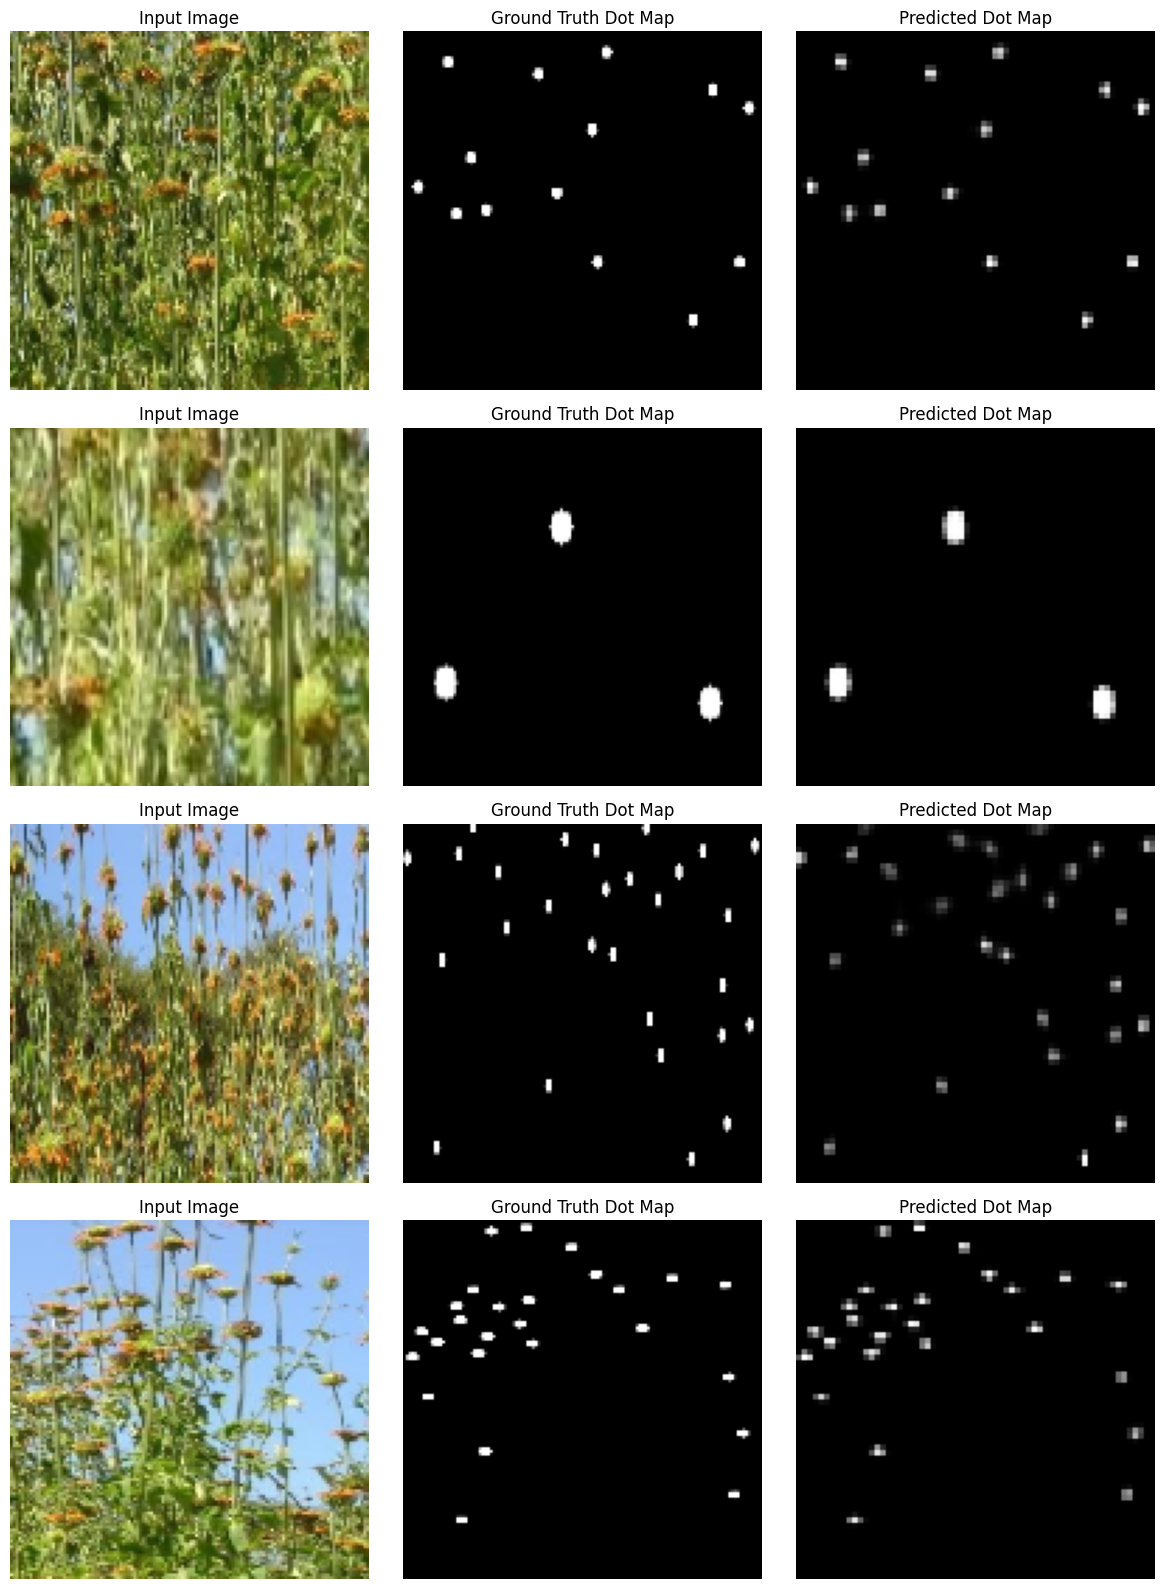

In [112]:
plot_predictions_from_generator(model, train_gen, n=5)

In [113]:
#import os
#import subprocess
#
#input_dir = "files/cropped"
#output_dir = "files/cropped_png"
#
## Create output directory if it doesn't exist
#os.makedirs(output_dir, exist_ok=True)
#
## Valid input extensions
#valid_exts = ('.jpg', '.jpeg', '.JPG', '.JPEG')
#
## Loop through input directory
#for filename in os.listdir(input_dir):
#    if filename.endswith(valid_exts):
#        input_path = os.path.join(input_dir, filename)
#        name_base = os.path.splitext(filename)[0]
#        output_path = os.path.join(output_dir, f"{name_base}.png")
#
#        # Run ffmpeg command
#        subprocess.run([
#            'ffmpeg', '-y', '-i', input_path, output_path
#        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#
#        print(f"[✓] Converted: {filename} → {name_base}.png")
#